## 0. Intro 

The aim of this notebook is to demonstrate **Gradient Descent** for **regression** problems, the concepts of **under/over-fitting**, and **regularization**.

 
We will use the [diabetes](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html) dataset. Our task is to predict disease progression of diabetes, given some variables such as age, sex, body mass index, blood pressure and blood serum measurements. 

For more details, follow the link above.

In [26]:
import torch
from torch import nn

from sklearn import model_selection
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sn

from IPython import display

import typing
%matplotlib inline

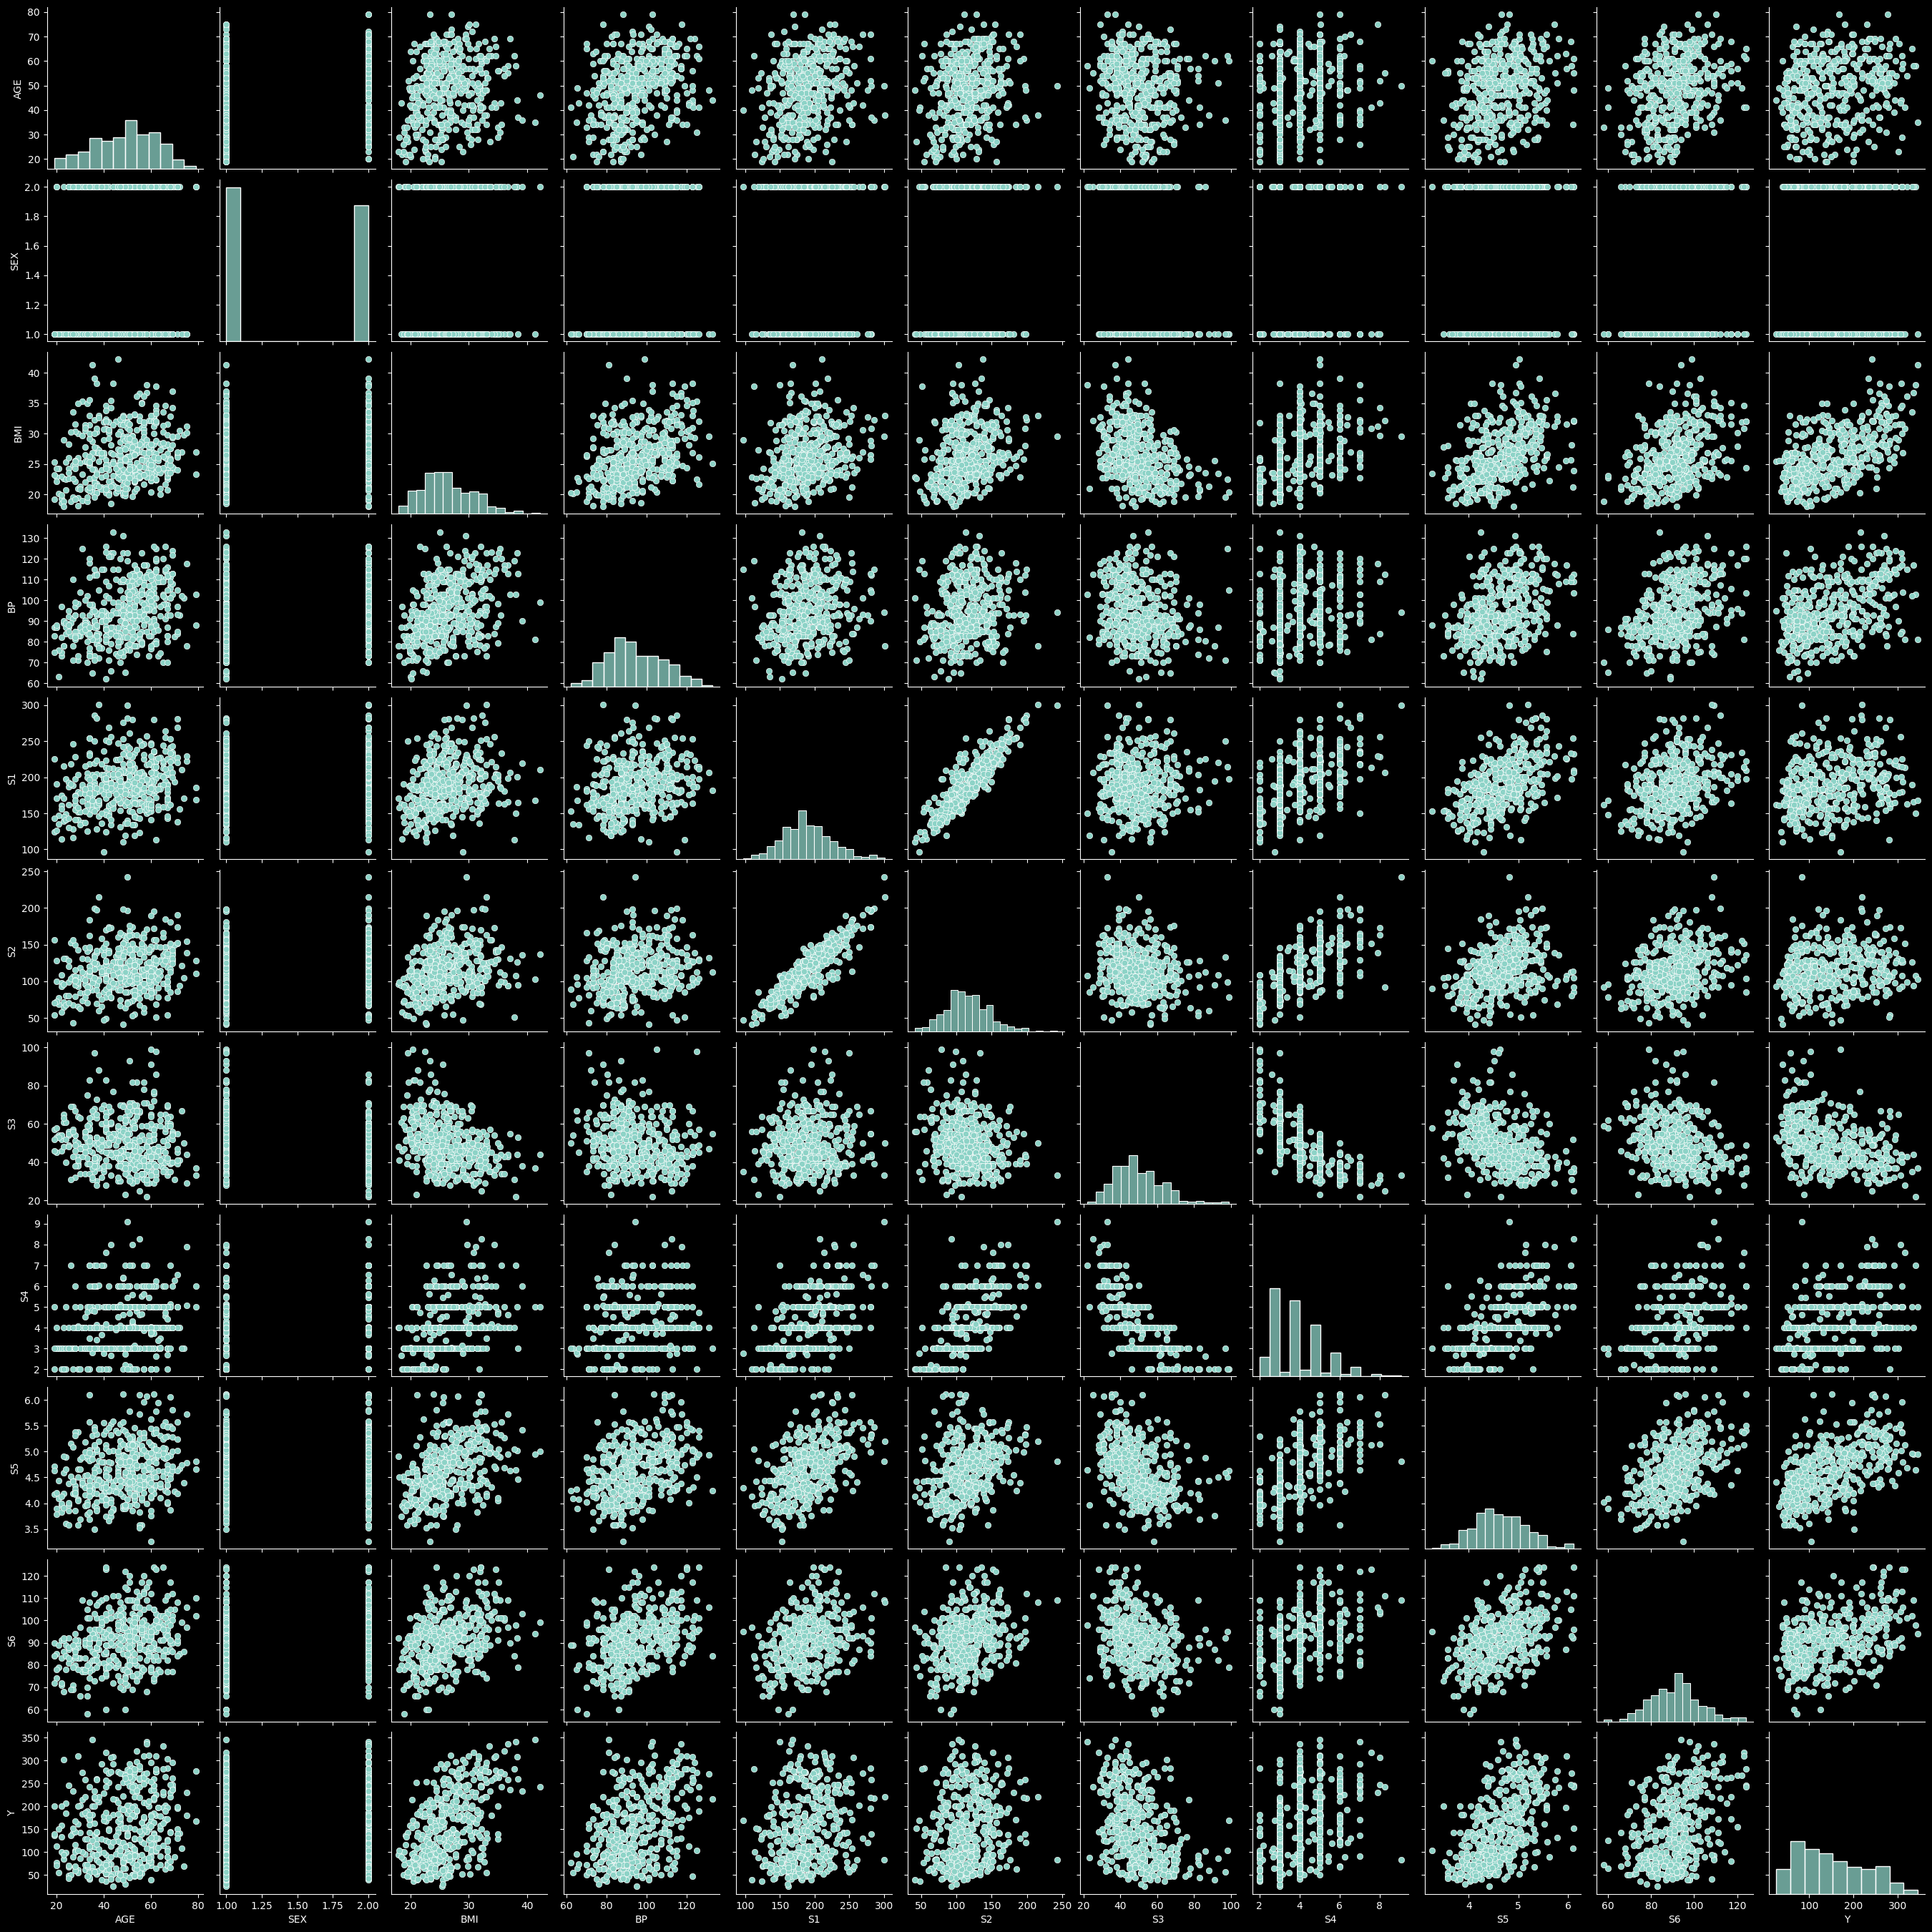

In [27]:
diabetes_db = pd.read_csv('https://www4.stat.ncsu.edu/~boos/var.select/diabetes.tab.txt', sep='\t', header=0)
sn.pairplot(diabetes_db)

In [28]:
diabetes_db.head(10)

,AGE,SEX,BMI,BP,S1,S2,S3,S4,S5,S6,Y
0,59,2,32.1,101.0,157,93.2,38.0,4.00,4.8598,87,151
1,48,1,21.6,87.0,183,103.2,70.0,3.00,3.8918,69,75
2,72,2,30.5,93.0,156,93.6,41.0,4.00,4.6728,85,141
3,24,1,25.3,84.0,198,131.4,40.0,5.00,4.8903,89,206
4,50,1,23.0,101.0,192,125.4,52.0,4.00,4.2905,80,135
5,23,1,22.6,89.0,139,64.8,61.0,2.00,4.1897,68,97
6,36,2,22.0,90.0,160,99.6,50.0,3.00,3.9512,82,138
7,66,2,26.2,114.0,255,185.0,56.0,4.55,4.2485,92,63
8,60,2,32.1,83.0,179,119.4,42.0,4.00,4.4773,94,110
9,29,1,30.0,85.0,180,93.4,43.0,4.00,5.3845,88,310


We first split the data into test and training sets. For consistency and to allow for meaningful comparison the same splits are maintained in the remainder of the lab.

In [29]:
X_train, X_test, y_train, y_test = model_selection.train_test_split(
    diabetes_db.loc[:, diabetes_db.columns != 'Y'],
    diabetes_db['Y'],
    test_size=0.2,
    random_state=42
    )

x_train = torch.from_numpy(X_train.values).float()
x_test = torch.from_numpy(X_test.values).float()

y_train = torch.from_numpy(y_train.values).float()
y_train = y_train.reshape(-1, 1)

y_test = torch.from_numpy(y_test.values).float()
y_test = y_test.reshape(-1, 1)

We can see that all the independent variables are on different scales. This can affect gradient descent, we therefore need to normalize all features to zero mean, and unit standard deviation. The normalized value $z_i$ of $x_i$ is obtained through $z_i = \frac{x_i - μ}{σ}$ where $μ$ is the mean and $σ$ is the standard deviation of $X$ and $x_i, μ, σ ∈ \mathbb{R}^D$.

**1.** Below we normalize `x_train, x_test` 

In [30]:
def norm_set(x: torch.Tensor, mu: torch.Tensor, sigma: torch.Tensor) -> torch.tensor:
   
  return (x-mu)/sigma

mu_train = torch.mean(x_train, dim=0)
sigma_train = torch.std(x_train, dim=0)

x_train = norm_set(x = x_train, mu = mu_train, sigma = sigma_train) 
x_test = norm_set(x = x_test,mu = mu_train, sigma = sigma_train) 
x_test.shape,x_train.shape

(torch.Size([89, 10]), torch.Size([353, 10]))

## 1.1 Linear Regression

We will building the linear regression model in pytorch using a custom layer.

Refering back to the lecture notes, we define $ y = f(x) = w^T x$, so we need to learn weight vector $w$.

**2.** Forward method of the LinearRegression class. 

In [31]:
class LinearRegression(nn.Module):
  def __init__(self, num_features):
    super().__init__()
    self.weight = nn.Parameter(torch.ones(1, num_features), requires_grad=False)

  def forward(self, x):
    y = torch.matmul(x, self.weight.T) 
    
    return y


As we need to account for the bias, we add a column of ones to the `x_data`

In [32]:
# add a feature for bias
x_train = torch.cat([x_train, torch.ones(x_train.shape[0], 1)], dim=1)
x_test = torch.cat([x_test, torch.ones(x_test.shape[0], 1)], dim=1)

In [33]:
## test the custom layer
model = LinearRegression(x_train.shape[1])
prediction = model(x_train)
prediction.shape # the output should be Nx1


torch.Size([353, 1])

The next step is to calculate the cost. For this we will use the mean squared error $E(w) = \frac{1}{N} Σ_{i=0}^N (f(x_i) - y_i)^2$

**3.** Below we calculate the squared error of for any set of labels $y$ and predictions 

In [34]:
def mean_squared_error(y_pred: torch.Tensor, y_true: torch.Tensor) -> torch.Tensor:
   
  mse = ((y_pred-y_true)**2).mean()
  return  mse

In [35]:
cost = mean_squared_error(y_train, prediction)
print(cost)

tensor(29029.5645)


We see that using a random set of initial parameters for bias and weight, yields a relatively high error. As such, we will update the values for $w$ using gradient descent. We will implement a custom method for gradient descent.

**4.** In the method below, add your code to update bias and weight using learning rate $α$.  

First we calculate the partial derivative of the loss function with respect to the weights.

We then update the weights vector using the following equation:

$ weight = weight - α * ∂_{weight}$

In [36]:
def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float) -> None:
  
  weight = model.weight
  N = X.shape[0] 
  
  # calculate the partial derivative of the loss function with respect to w
  w_der = -(2/N)*(torch.sum( (y-y_pred) * X, dim =0 )) 
 
  # calculate the new values the weights
  weight -= lr*w_der.T
  model.weight = nn.Parameter(weight, requires_grad=False)

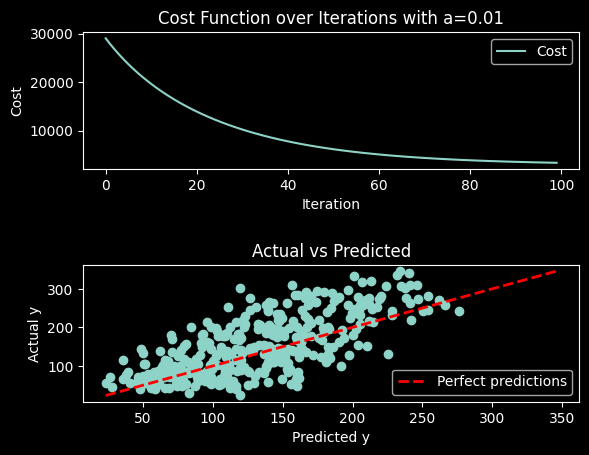

Parameter containing:
tensor([[  2.0440,  -8.9550,  23.8555,  15.2730,  -3.3063,  -5.4048,  -9.5767,
           7.1891,  17.6155,   5.7776, 133.4807]])
Minimum cost: 3351.271240234375


In [37]:
cost_lst = list()
model = LinearRegression(x_train.shape[1])
alpha = .01

for it in range(100):
  prediction = model(x_train)
  cost = mean_squared_error(y_train, prediction)
  cost_lst.append(cost)
  gradient_descent_step(model, x_train, y_train, prediction, alpha)


fig, axs = plt.subplots(2)
plt.subplots_adjust(hspace=0.7) 

axs[0].plot(list(range(it+1)), cost_lst, label="Cost")  
axs[0].set_title(f"Cost Function over Iterations with a={alpha}")
axs[0].set_xlabel("Iteration")
axs[0].set_ylabel("Cost")
axs[0].legend()
 
min_val = min(min(prediction), min(y_train)) 
max_val = max(max(prediction), max(y_train)) 
axs[1].plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', linewidth=2, label='Perfect predictions')
axs[1].scatter(prediction, y_train)
axs[1].set_title("Actual vs Predicted")
axs[1].set_xlabel("Predicted y")
axs[1].set_ylabel("Actual y") 
axs[1].legend()

plt.show()


print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))

**5.** What conclusion if any can be drawn from the weight values? How does sex and BMI affect diabetes disease progression?

What are the estimated disease progression values for the below examples?  

| AGE | SEX | BMI | BP  | S1  | S2    | S3 | S4  | S5     | S6  |
|-----|-----|-----|-----|-----|-------|----|-----|--------|-----|
| 25  | F   | 18  | 79  | 130 | 64.8  | 61 | 2   | 4.1897 | 68  |
| 50  | M   | 28  | 103 | 229 | 162.2 | 60 | 4.5 | 6.107  | 124 |

In [38]:
def preprocess_data(x: torch.Tensor, x_train: torch.Tensor):

    x = norm_set(x,torch.mean(x_train,dim=0), sigma = torch.std(x_train,dim=0))  #Normalise with test_data stats to not introduce bias
    x = torch.cat([x, torch.ones(x.shape[0], 1)], dim=1)
   
    return x

# 1 = Male, 2 = Female 
#columns = ['AGE', 'SEX', 'BMI', 'BP', 'S1', 'S2', 'S3', 'S4', 'S5', 'S6']
x = torch.Tensor( [[25, 2, 18, 79, 130, 64.8, 61, 2, 4.1897, 68],
                   [50, 1 , 28, 103, 229, 162.2, 60, 4.5, 6.107, 124]] 
                    )
 
model( preprocess_data(x,torch.from_numpy(X_train.values).float()) )

tensor([[ 23.3806],
        [205.6958]])

Error on the test set:


In [39]:
mean_squared_error(y_true=y_test, y_pred= model(x_test) ) 

tensor(3425.4438)

The model represents well the dataset as the test error is very close to the train error. Therefore we can make a reasonable assumption that the model is not over/under fitting the data. 

This is because for overfitting we would have a much higher test error value compared to the train set one and the model wouldn't have the ability to generilise well.
Underfitting on the other hand, we would observe both high training and test errors, indicating that the model struggles to capture the underlying patterns in the data. This would mean that there isn't enough complexity to accurately represent the data and performance on both training and test sets would be very low. This is not the case as the final train test error is approx 3400 whereas the initial error was around 29000

**6.** Below we fit a model with several learning rates that differ by orders of magnitude, and record the training and test set errors.

In [40]:

lrs = np.linspace(0.001,0.5,125)
train_cost_lst = []
test_cost_lst = []

for alpha in lrs:
   
    model = LinearRegression(x_train.shape[1])
     
    for it in range(100):
        prediction = model(x_train)
        cost = mean_squared_error(y_train, prediction)
        gradient_descent_step(model, x_train, y_train, prediction, alpha)

    train_cost_lst.append(cost)

    test_error = mean_squared_error(y_true=y_test, y_pred= model(x_test) )
    test_cost_lst.append(test_error)  


lr_cost_df = pd.DataFrame({
    'LearningRate': lrs,
    'TrainCost': train_cost_lst,
    'TestCost': test_cost_lst
})

lr_cost_df.head(3)

,LearningRate,TrainCost,TestCost
0,0.001000,tensor(19769.7012),tensor(18346.2441)
1,0.005024,tensor(6221.6992),tensor(6235.0991)
2,0.009048,tensor(3561.6650),tensor(3643.8704)


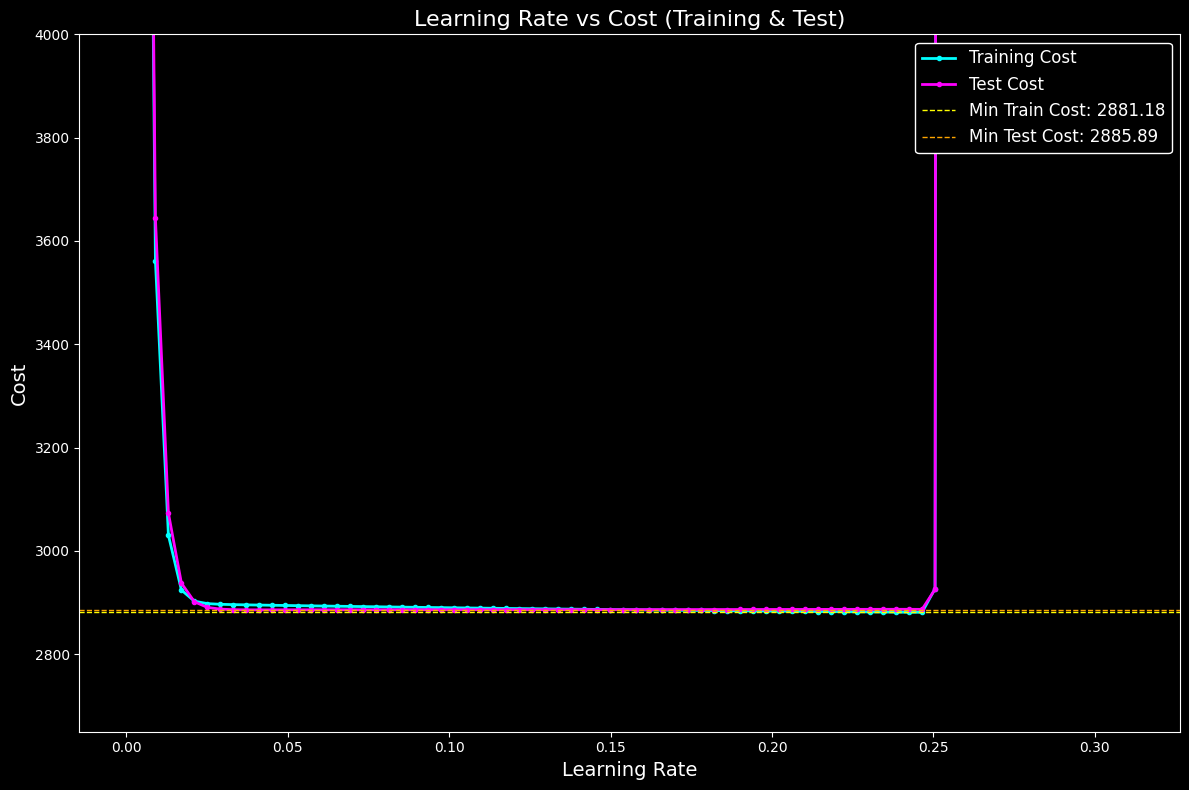

In [41]:
plt.style.use('dark_background')   
fig, ax = plt.subplots(figsize=(12, 8))


ax.plot(lrs, train_cost_lst, color='cyan', marker='o', linestyle='-', linewidth=2, markersize=3, label='Training Cost')
ax.plot(lrs, test_cost_lst, color='magenta', marker='o', linestyle='-', linewidth=2, markersize=3, label='Test Cost')

min_y_value = min(train_cost_lst)
ax.axhline(y=min_y_value, color='yellow', linestyle='--', linewidth=1, label=f'Min Train Cost: {min_y_value:.2f}')

min_test_y_value = min(test_cost_lst)
ax.axhline(y=min_test_y_value, color='orange', linestyle='--', linewidth=1, label=f'Min Test Cost: {min_test_y_value:.2f}')

ax.set_xlabel('Learning Rate', fontsize=14, color='white')
ax.set_ylabel('Cost', fontsize=14, color='white')
ax.set_title('Learning Rate vs Cost (Training & Test)', fontsize=16, color='white')
ax.set_ylim(2650, 4000)

ax.spines['bottom'].set_color('white')
ax.spines['left'].set_color('white')
ax.xaxis.label.set_color('white')
ax.yaxis.label.set_color('white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend(loc='upper right', fontsize=12, facecolor='black', edgecolor='white', framealpha=1)

plt.tight_layout()
plt.show()


# 1.2 Regularized Linear Regression
In this section, we will be trying to create a model that fits data that is clearly not linear. We will be attempting to fit the data points seen in the graph below:

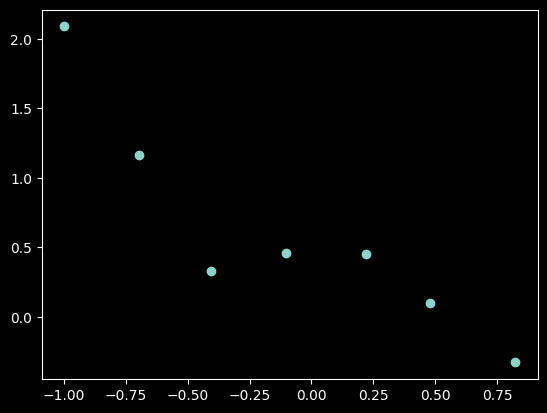

In [42]:
x = torch.tensor([-0.99768, -0.69574, -0.40373, -0.10236, 0.22024, 0.47742, 0.82229])
y = torch.tensor([2.0885, 1.1646, 0.3287, 0.46013, 0.44808, 0.10013, -0.32952]).reshape(-1, 1)
plt.scatter(x, y)
plt.show()

In order to fit this data we will create a new hypothesis function, which uses a fifth-order polynomial:

$
 h_{\theta}(x) = \theta_{0} x_{0} + \theta_{1} x_{1} + \theta_{2} x_{1} ^2 + \theta_{3} x_{1} ^3 + \theta_{4} x_{1} ^4 + \theta_{5} x_{1} ^5
$

As we are fitting a small number of points with a high order model, there is a danger of overfitting.  \\

To attempt to avoid this we will use regularization. Our cost function becomes:

$
 J(\theta) = \frac{1}{2m}  \left[ \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})^2 + \lambda    \sum_{j=1}^n \theta_{j}^2 \right]
$

We adjust variable `x` to include the different powers of $x_{1}$ as described by the hypothesis function. e.g $x_{1}, x_{1} ^2, ..., x_{1}^5$. and include $x_0$ which is our bias term.

In [44]:
x3 = torch.stack([torch.ones(x.shape[0]), x, x**2, x**3, x**4, x**5], dim=1)
x3.shape 

torch.Size([7, 6])

**7.** We update the cost and gradient descent methods to use the regularised cost, as shown above.  

Note that the punishment for having more terms is not applied to the bias. This means that we use a different update technique for the partial derivative of $\theta_{0}$, and add the regularization to all of the others:



$
 \theta_{j} =  \theta_{j} - \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j=0
$



$
 \theta_{j} =  \theta_{j} (1 - \alpha \frac{\lambda}{m}) -
 \alpha \frac{1}{m} \sum_{i=1}^m ( h_{\theta}(x^{(i)}) - y^{(i)})x^{(i)}_{j} , j>0
$

In [45]:
def mean_squared_error(y_true: torch.Tensor, y_pred: torch.Tensor, lam: float, theta: torch.tensor) -> torch.Tensor:
   
  N = len(y_pred)
  cost_fun = (1/(2*N)) * ( ((y_pred-y_true)**2).sum() + lam*(theta**2).sum() )
 
  return cost_fun 

def gradient_descent_step(model: nn.Module, X: torch.Tensor, y: torch.Tensor, y_pred: torch.Tensor, lr: float, lam: float) -> None:
  weight = model.weight
  N = X.shape[0] #Sample length
  n = model.weight.shape[1] #Length of weight vector
  
  w0  = (weight[0,0] - (lr/N) * torch.dot( (y_pred - y).squeeze() , X[:,0] )).unsqueeze(0)
  w1  = weight[0,1:n]*(1-lr*lam/N)  - (lr/N) * torch.sum((y_pred - y) * X[:,1:n], dim=0) 
  weight = torch.cat((w0,w1), dim=0).view(1, -1)
  
  model.weight = nn.Parameter(weight, requires_grad=False)

**8.** Below we optimize w.r.t. the alpha value and then experiment with different values of $\lambda$ and see how this affects the shape of the hypothesis. 

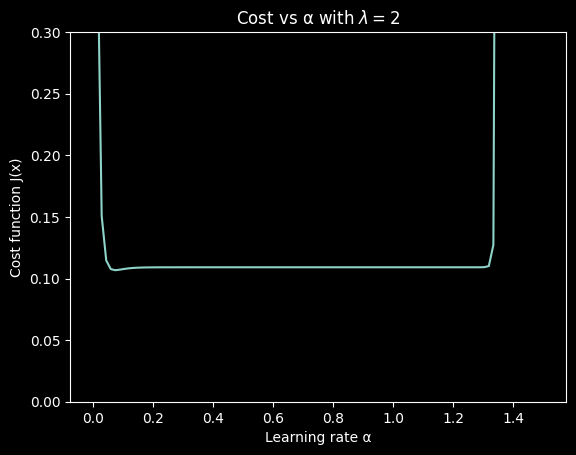

Parameter containing:
tensor([[-3.5104e+08,  1.6873e+08, -2.2498e+08,  1.4698e+08, -1.7973e+08,
          1.3918e+08]])
Minimum cost: 0.10673841834068298


In [46]:
cost_lst = []
alphas  = np.linspace(0,1.5,100)
 
for alpha in alphas:  
  
  model = LinearRegression(x3.shape[1])
  lam =  2  # select an appropriate lambda

  for it in range(100):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
  cost_lst.append(cost)
display.clear_output(wait=True)

plt.plot(alphas, cost_lst)
plt.ylim(0,0.3)
plt.title(fr'Cost vs α with $\lambda = {lam} $')
plt.xlabel("Learning rate α")
plt.ylabel("Cost function J(x)")
plt.show()
print(model.weight)
print('Minimum cost: {}'.format(min(cost_lst)))


**Based on the plot above we choose an alpha value of 0.3 as the error decreases quickly without instability, and we reach closely to the minimum error efficiently.**


In [47]:
def plot_poly(w,x,y,title,color):
    """
    Plots a 5th order polynomial based on the provided weights and data points.
    Args:
        w: 2D tensor containing the polynomial coefficients in the form 
                          `w = [[w0, w1, w2, w3, w4, w5]]`, where the polynomial is:
                          y = w0 + w1 * x + w2 * x^2 + w3 * x^3 + w4 * x^4 + w5 * x^5.
        x: input data points.
        y:actual values 

    Returns:
        The plot.
 
    """
    def polynomial(x, w):
        # f(x) =  w0 + w1 * x + w2 * x^2 + w3 * x^3 + w4 * x^4 + w5 * x^5
        return (w[0, 0] + w[0, 1] * x + w[0, 2] * x**2 +
                w[0, 3] * x**3 + w[0, 4] * x**4 + w[0, 5] * x**5)

    x_vals = np.linspace(min(x) - 4, max(x) + 4, 400)
    y_vals = polynomial(x_vals, w).detach().numpy()

    plt.plot(x_vals, y_vals, label=title, color=color)  
    plt.scatter(x, y, color='blue')
    plt.xlim(min(x) - 0.99768, max(x) + 0.82229)
    plt.ylim(min(y) - 0.99768, max(y) + 0.82229)
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.grid(True)
    plt.legend() 

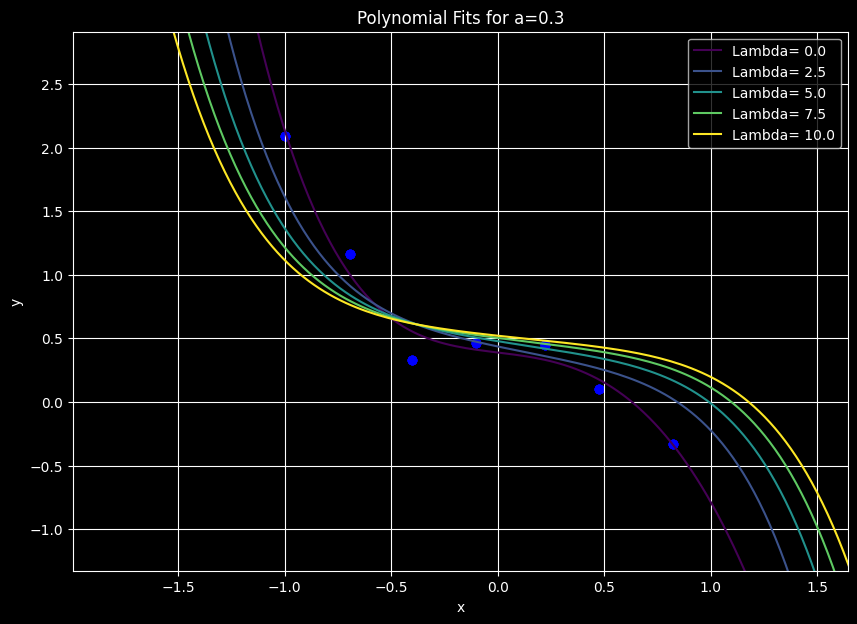

In [48]:
alpha = 0.3
lambdas = np.linspace(0, 10, 5)
colors = plt.cm.viridis(np.linspace(0, 1, len(lambdas)))  

plt.figure(figsize=(10, 7))
for i, lam in enumerate(lambdas):
    model = LinearRegression(x3.shape[1])

    for it in range(1000):
        prediction = model(x3)
        cost = mean_squared_error(y, prediction, lam, model.weight)
        gradient_descent_step(model, x3, y, prediction, alpha, lam)
    cost_lst.append(cost)

    plot_poly(model.weight, x, y, title=f'Lambda= {lam}', color= colors[i] )

plt.title(f'Polynomial Fits for a={alpha}')
plt.show()

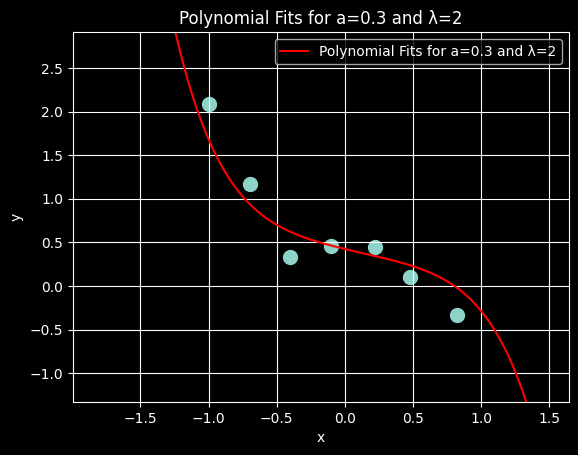

In [49]:
alpha = 0.3
lam =  2 

model = LinearRegression(x3.shape[1]) 

for it in range(1000):
    prediction = model(x3)
    cost = mean_squared_error(y, prediction, lam, model.weight)
    gradient_descent_step(model, x3, y, prediction, alpha, lam)
    cost_lst.append(cost)



plot_poly(model.weight, x, y, title = f'Polynomial Fits for a={alpha} and λ={lam}', color = 'red')
plt.scatter(x,y, s =100)
plt.xlabel('x')
plt.ylabel('y') 
plt.grid(True)  
plt.show()

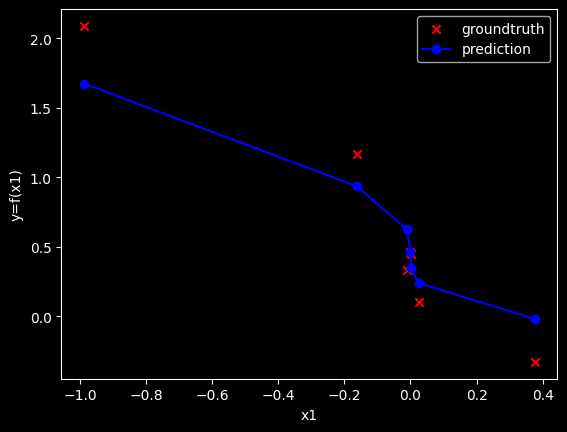

In [ ]:
plt.scatter(x3[:, -1], y, c='red', marker='x', label='groundtruth')
outputs = model(x3)
plt.plot(x3[:, -1], outputs, c='blue', marker='o', label='prediction')
plt.xlabel('x1')
plt.ylabel('y=f(x1)')
plt.legend()
plt.show()